# CS5785 Assignment1 PA1-1. Digit Recognizer

## Task 1-(a)
## Dataset: 
    https://www.kaggle.com/c/digit-recognizer/data?select=train.csv
## Format: 
    .csv
## Description:
    Each row of training data has 785 columns. Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import scipy
import os
import random
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, classification_report, plot_confusion_matrix

DIGITS = range(10)

## Task 1-(a) Load data

In [2]:
PATH_TO_DATASET = "./digit-recognizer"
train_data = pd.read_csv(os.path.join(PATH_TO_DATASET, "train.csv") )
train_data = train_data.sample(frac=1).reset_index(drop=True) # shuffle
train_x, train_y = train_data.iloc[:, 1:].values, train_data.iloc[:, [0]].values
# trian_x shape: [?, 784]
# train_y shape: [?,   1]
test_data  = pd.read_csv(os.path.join(PATH_TO_DATASET, "test.csv"))
test_x = test_data.values
# test_x shape:[?, 784]
print("Training feature shape: {}".format(train_x.shape))
print("Training label shape: {}".format(train_y.shape))
print("Test feature shape: {}".format(test_data.shape))


Training feature shape: (42000, 784)
Training label shape: (42000, 1)
Test feature shape: (28000, 784)


## Task 1-(b) Display random samples

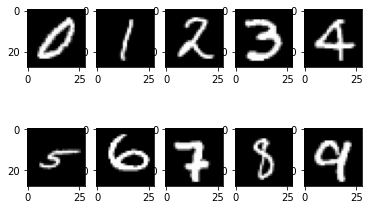

In [3]:
sampled = set([]) 
sample_map = [None] * len(DIGITS)# stores one sample for each digit

i = 0
while i < train_data.shape[0] and len(sampled) < len(DIGITS):
    sample_map[train_y[i][0]] = train_x[i]
    sampled.add(train_y[i][0])
    i+=1
sample_map = np.array(sample_map) 
    
fig = plt.figure()
columns, rows = 5, 2
for i in range(0, columns*rows):
    img = sample_map[i].reshape(28,28)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap = plt.cm.gray) #0 to 255
plt.show()

    

## Task 1-(c)

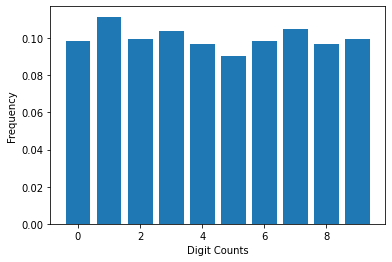

In [4]:
counts = np.array([0] * len(DIGITS))

for i in range(len(train_data)):
    counts[train_y[i][0]] += 1

counts = counts*1.0 / train_data.shape[0]

    
plt.bar(DIGITS,counts,align='center') # A bar chart
plt.xlabel('Digit Counts')
plt.ylabel('Frequency')
plt.show()

## Task 1-(d) & 1-(g) 

In [5]:
class KNNClassifier:
    
    def __init__(self, n_neighbors = 1):
        self.k = n_neighbors
    
    def __predict_info__(self, X, exclude_self = False):
        num_test = X.shape[0]
        num_train = self.train_x.shape[0]
        dists = np.zeros((num_test, num_train)) 
        #l2 norm = (x - x')^2 = x^2 + x'^2 + 2xx'
        dists = np.reshape(np.sum(X**2,axis = 1), [num_test,1]) + np.sum(self.train_x**2, axis = 1)\
                - 2*np.matmul(X, self.train_x.T)
        dists = np.sqrt(dists)
        if exclude_self:
            dists = np.where(dists != 0, dists, float("inf"))
        inds = np.argsort(dists, axis = 1)
        votes = np.reshape(self.train_y[inds[:,:self.k]], (num_test,self.k))
        closest_ind = inds[:,0]
        closest_dist = dists[np.arange(len(dists)),  closest_ind]
        return votes, closest_ind, closest_dist
    
    def fit(self, x, y):
        self.train_x = x
        self.train_y = y
        
        
    def predict(self, X, exclude_self = False, get_match_info = False):
        
        votes, closest_ind, closest_dist = self.__predict_info__(X, exclude_self)
        counts = np.apply_along_axis(lambda x: np.bincount(x, minlength = 10), axis=1, arr=votes)
        pred = np.reshape(np.argmax(counts,axis = 1), [len(X), 1])
        
        if not get_match_info: return pred
        return pred, closest_ind, closest_dist
    
    def predict_proba(self, X, exclude_self = False):
        votes, _, _ = self.__predict_info__(X, exclude_self)
        counts = np.apply_along_axis(lambda x: np.bincount(x, minlength = 10), axis=1, arr=votes)
        probas = counts*1.0/np.reshape(np.sum(counts, axis = 1), [len(counts),1])
        return probas
       
    def score(self, X, y ):
        """
        X: test input
        y: test label
        """
        pred = self.predict(X)
        return np.sum(pred == y)*1.0/len(y)

In [6]:
#we reuse sample_map from task 1-(b)

model = KNNClassifier(1)
model.fit(train_x, train_y)
res, dist, ind = model.predict(sample_map, exclude_self = True, get_match_info = True)

for i in range(len(res)):
    print("Select Data with Digit: {} Predicted:{}".format(i, res[i][0] \
                                                if res[i][0]  == i else "*" + str(res[i][0])))
    print("Additional Info:")
    print("\tDistance(L2 norm, 255 scale): {}".format(dist[i]))
    print("\tMatched training data index:  {}".format(ind[i]))
    print()



Select Data with Digit: 0 Predicted:0
Additional Info:
	Distance(L2 norm, 255 scale): 27796
	Matched training data index:  985.6890990571013

Select Data with Digit: 1 Predicted:1
Additional Info:
	Distance(L2 norm, 255 scale): 18980
	Matched training data index:  394.0279177926356

Select Data with Digit: 2 Predicted:2
Additional Info:
	Distance(L2 norm, 255 scale): 817
	Matched training data index:  1251.023580912846

Select Data with Digit: 3 Predicted:3
Additional Info:
	Distance(L2 norm, 255 scale): 10949
	Matched training data index:  1448.9071743904094

Select Data with Digit: 4 Predicted:4
Additional Info:
	Distance(L2 norm, 255 scale): 9212
	Matched training data index:  1340.682661930108

Select Data with Digit: 5 Predicted:5
Additional Info:
	Distance(L2 norm, 255 scale): 25800
	Matched training data index:  819.6365047995362

Select Data with Digit: 6 Predicted:6
Additional Info:
	Distance(L2 norm, 255 scale): 32930
	Matched training data index:  1056.5278037041903

Select 

## Task 1-(e)

In [7]:
#form up 0-1 dataset
zo_x = []
zo_y = []
for i in range(train_data.shape[0]):
    if train_data['label'][i] == 0 or train_data['label'][i] == 1:
        zo_x += [train_data.values[i][1:]]
        zo_y += [[train_data['label'][i]]]
        
zo_x = np.array(zo_x)
zo_y = np.array(zo_y)

print("Zero/One dataset X shape: {}".format(zo_x.shape))
print("Zero/One dataset Y shape: {}".format(zo_y.shape))

Zero/One dataset X shape: (8816, 784)
Zero/One dataset Y shape: (8816, 1)


In [8]:
batch_size = 512

g_dists, i_dists = [], []
all_dists = None
for i in range(len(zo_y) // batch_size + 1):
    if i % 1 == 0:
        print("Batch calculation {} out of {}".format(i, len(zo_y) // batch_size))
    in_x = zo_x[batch_size*i:batch_size*(i+1)]
    in_y = zo_y[batch_size*i:batch_size*(i+1)]
    num_test = in_x.shape[0]
    num_train = zo_x.shape[0]
    dists = np.zeros((num_test, num_train)) 
    dists = np.reshape(np.sum(in_x**2,axis = 1), [num_test,1]) + np.sum(zo_x**2, axis = 1)\
                    - 2*np.matmul(in_x, zo_x.T)

    dists = np.sqrt(dists)
    if all_dists is None:
        all_dists = dists
    else:
        all_dists = np.concatenate((all_dists,dists))
    g_mask = (in_y==zo_y.T).astype(np.int32)
    
    g_dists += list(np.unique(dists*g_mask)[1:])
    i_dists += list(np.unique(dists*(1-g_mask))[1:])
    
g_dists = set(g_dists)
i_dists = set(i_dists)
print("Done.")

Batch calculation 0 out of 17
Batch calculation 1 out of 17
Batch calculation 2 out of 17
Batch calculation 3 out of 17
Batch calculation 4 out of 17
Batch calculation 5 out of 17
Batch calculation 6 out of 17
Batch calculation 7 out of 17
Batch calculation 8 out of 17
Batch calculation 9 out of 17
Batch calculation 10 out of 17
Batch calculation 11 out of 17
Batch calculation 12 out of 17
Batch calculation 13 out of 17
Batch calculation 14 out of 17
Batch calculation 15 out of 17
Batch calculation 16 out of 17
Batch calculation 17 out of 17
Done.


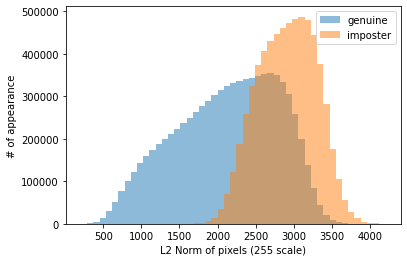

In [9]:
bins = np.linspace(min(min(g_dists), min(i_dists)), max(max(g_dists), max(i_dists)), 50)
plt.hist(list(g_dists), bins, alpha=0.5, label='genuine')
plt.hist(list(i_dists), bins, alpha=0.5, label='imposter')
plt.xlabel('L2 Norm of pixels (255 scale)')
plt.ylabel('# of appearance')
plt.legend(loc='upper right')
plt.show()

## Task 1-(f)

In [20]:
#distance to probability
true_mask = np.reshape(zo_y, (1,len(zo_y)))
true_mask = np.repeat(true_mask, len(zo_y))
true_mask = np.reshape(true_mask, (len(zo_y),len(zo_y))).T

true_val = np.sum(all_dists * true_mask, axis = 1)
false_val = np.sum(all_dists * (1-true_mask), axis = 1) 


In [31]:
scores = 1 - true_val/(true_val + false_val)
#rescale scores

In [32]:
y_true = np.reshape(zo_y, [len(zo_y),])

In [33]:
fpr, tpr, threshold = roc_curve(y_true, y_scores)

In [34]:
print(fpr)
print(tpr)
print(threshold)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.42013553e-04
 2.42013553e-04 4.84027106e-04 4.84027106e-04 7.26040658e-04
 7.26040658e-04 9.68054211e-04 9.68054211e-04 1.45208132e-03
 1.45208132e-03 1.69409487e-03 1.69409487e-03 1.93610842e-03
 1.93610842e-03 2.42013553e-03 2.42013553e-03 2.66214908e-03
 2.66214908e-03 2.90416263e-03 2.90416263e-03 3.14617619e-03
 3.14617619e-03 3.38818974e-03 3.38818974e-03 3.63020329e-03
 3.63020329e-03 4.84027106e-03 4.84027106e-03 5.32429816e-03
 5.32429816e-03 5.80832527e-03 5.80832527e-03 6.05033882e-03
 6.05033882e-03 6.29235237e-03 6.29235237e-03 6.77637948e-03
 6.77637948e-03 7.01839303e-03 7.01839303e-03 7.26040658e-03
 7.26040658e-03 9.43852856e-03 9.43852856e-03 1.25847047e-02
 1.25847047e-02 1.33107454e-02 1.33107454e-02 4.69506292e-02
 4.69506292e-02 1.00000000e+00]
[0.00000000e+00 2.13492741e-04 9.58582408e-01 9.58582408e-01
 9.77583262e-01 9.77583262e-01 9.83134073e-01 9.83134073e-01
 9.83561059e-01 9.83561059e-01 9.90392827e-01 9.90392

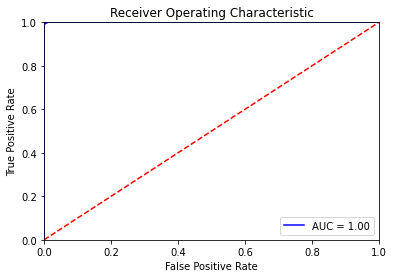

In [35]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Task 1-(h)

In [3]:
#since we shuffle data in Task 1-(b), we no longer shuffle
hold_out_portion = 0.15
ho_train_x = train_x[:int(len(train_x)*(1-hold_out_portion))]
ho_train_y = train_y[:int(len(train_y)*(1-hold_out_portion))]
ho_val_x = train_x[int(len(train_x)*(1-hold_out_portion)):]
ho_val_y = train_y[int(len(train_y)*(1-hold_out_portion)):]

print("[INFO] Splitting data with hold-out validation 15%")
print("Train X shape: {}".format(ho_train_x.shape))
print("Train Y shape: {}".format(ho_train_y.shape))
print("Validation X shape: {}".format(ho_val_x.shape))
print("Validation Y shape: {}".format(ho_val_y.shape))

[INFO] Splitting data with hold-out validation 15%
Train X shape: (35700, 784)
Train Y shape: (35700, 1)
Validation X shape: (6300, 784)
Validation Y shape: (6300, 1)


In [6]:
#we use sklearn KNN for faster searching K
k_possible = [1, 3, 5 ,7, 15, 20]
k_best, acc_best = -1, 0
ho_train_y = np.reshape(ho_train_y, (len(ho_train_y),))
h_val_y = np.reshape(ho_val_y, (len(ho_val_y),))
k_visited, acc_visited = [], []
for k in k_possible:
    print("K = {}".format(k))
    knn =  KNeighborsClassifier(n_neighbors=k)
    knn.fit(ho_train_x, ho_train_y)
    acc = knn.score(ho_val_x, ho_val_y)

    k_visited += [k]
    acc_visited += [acc]
    if acc > acc_best:
        acc_best = acc
        k_best = k
        
print("Select k in {},".format(k_possible))
print("Best accuracy = {} when k = {}".format(acc_best, k_best) )


K = 1
K = 3
K = 5
K = 7
K = 15
K = 20
Select k in [1, 3, 5, 7, 15, 20],
Best accuracy = 0.9692063492063492 when k = 1


In [12]:
table = pd.DataFrame({"K":k_visited, "Accuracy": acc_visited})

In [13]:
print(table)

    K  Accuracy
0   1  0.969206
1   3  0.968095
2   5  0.966825
3   7  0.966349
4  15  0.962063
5  20  0.956825


## Task 1-(i)

In [19]:
#train classifier with best K
knn =  KNeighborsClassifier(n_neighbors=k_best)
knn.fit(ho_train_x, ho_train_y)
disp = plot_confusion_matrix(knn, ho_val_x, ho_val_y,
                                 display_labels=DIGITS,
                                 cmap=plt.cm.Blues)
print("")

In [20]:
disp.ax_.set_title("Consufion matrix (using counts)")

print("Consufion matrix (using counts)")
print(disp.confusion_matrix)
plt.show()

Consufion matrix (using counts)
[[648   0   0   0   0   1   3   1   0   0]
 [  0 729   0   0   0   0   0   1   0   0]
 [  2   2 581   2   0   0   2   3   1   1]
 [  1   0   7 652   0   8   0   4   7   0]
 [  0   6   0   0 553   0   3   1   0  20]
 [  1   1   0   9   2 537   5   3   3   3]
 [  0   2   0   0   2   1 623   0   1   0]
 [  0   3   2   0   3   0   0 610   0  10]
 [  3   3   1   9   1   8   3   0 577   8]
 [  3   1   1   2  12   2   1   9   0 596]]


Digits: 4, 5, 8, 9 are more tricky to predict.

## Task 1-(j) 

In [21]:
print("Training feature shape: {}".format(train_x.shape))
print("Training label shape: {}".format(train_y.shape))
print("Test feature shape: {}".format(test_data.shape))

Training feature shape: (42000, 784)
Training label shape: (42000,)
Test feature shape: (28000, 784)


In [22]:
k_best = 1 #using result from validation set

In [23]:
#we use sklearn KNN for faster searching K
knn =  KNeighborsClassifier(n_neighbors=k_best)
train_y = np.reshape(train_y, (len(train_y),))
knn.fit(train_x, train_y)

pred = knn.predict(test_x)


In [35]:
output = pd.DataFrame({
    "ImageId":np.array(range(len(pred))) + 1,
    "Label":pred
})
output.set_index('ImageId', inplace=True)

         Label
ImageId       
1            2
2            0
3            9
4            0
5            3
...        ...
27996        9
27997        7
27998        3
27999        9
28000        2

[28000 rows x 1 columns]


In [36]:
pd.DataFrame.to_csv(output, "./predicted_digits.csv")

### Kaggle scoring result

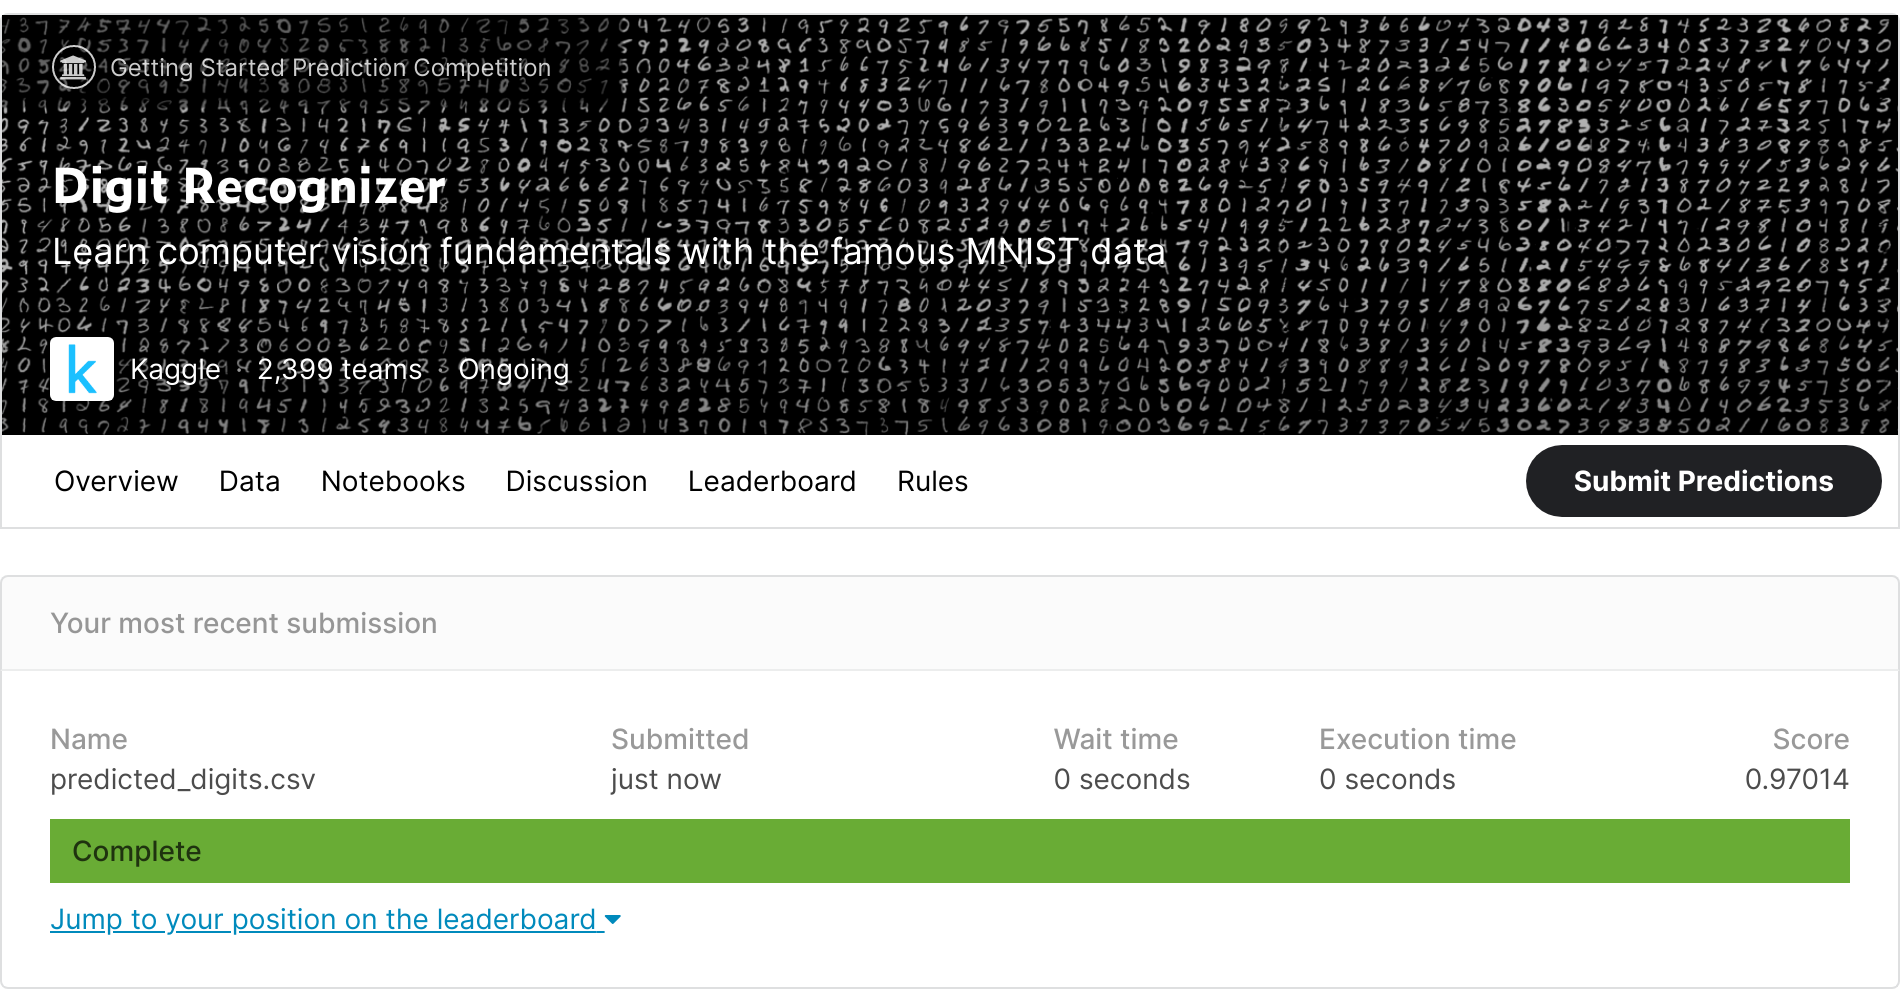

In [41]:
from IPython.display import Image
Image(filename='./result1.png') 